# IMDB Project

## Resources


- [Building A Logistic Regression in Python, Step by Step](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)

# Research

In [1]:
import pandas as pd
import numpy as np
import itertools
import operator
import matplotlib.pyplot as plt
import seaborn as sns

#################################
####==Statistics Libraries==####
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy
#################################

import networkx as nx

import qgrid
from pandas_profiling import ProfileReport

# from pandasgui import show
# from PyQt5 import QtCore, QtGui, QtWidgets



pd.options.display.max_rows     = None
pd.options.display.max_columns  = None

## Data Standardization Module

In [2]:
class DataModule:
    
    def __init__(self):
        self.dforig = self._import_data()
        self.dfconfig = self._config_original_df(dataframe=self.dforig)
        self.DF = self.dfconfig
        
        # self.df_actors = self._get_df_category(dataframe=self.dforig, target_column='Actors')
        self.df_genres = self._get_df_category(dataframe=self.dfconfig, target_column='Genre')
        # self.df_nGenres = self.df_genres.apply(lambda row: sum(row[:]), axis=1).to_frame().rename(columns={0:'n_Genre'})
        
        # self.mlr_genre2rev = self.get_MLR(self.df_genres, self.dforig[['Revenue_Millions']])
    
    def _import_data(self):
        df_raw = pd.read_csv("IMDB-Movie-Data.csv")
        df_raw = df_raw.rename(columns={
            'Runtime (Minutes)':'Runtime',    # minutes
            'Revenue (Millions)':'Revenue',  # millions of dollars
        })
        df_raw['hash'] = df_raw.apply(lambda x: hash(tuple(x)), axis=1)
        df_raw = df_raw.set_index('hash')
        return df_raw
    
    def _config_original_df(self, dataframe):
        df = dataframe
        
        df['Genre']   = df['Genre'].apply(lambda x: str(x).split(','))
        df['Actors']  = df['Actors'].apply(lambda x: [] if (isinstance(x,str)==False) else list(i.strip().upper() for i in str(x).split(',')))
        
        return df
        
    def _get_df_category(self, dataframe, target_column:str):
        df, target_column = dataframe, target_column
        
        hash2cats  = dict((k, [i.strip().upper() for i in v]) for k,v in df[target_column].to_dict().items())
        all_cats   = [s.strip().upper() for s in list(set(itertools.chain.from_iterable(list(hash2cats.values()))))]
        
        hash2allCats = {}
        for h,cats in hash2cats.items():
            hash2allCats[h] = {}
            for c in all_cats:
                if c in cats:
                    hash2allCats[h][c] = 1
                else:
                    hash2allCats[h][c] = 0
               
        df_cats = pd.DataFrame.from_dict(hash2allCats).T
        df_cats.index.name = 'hash'
        return df_cats
    
    def getNormalized(self, dataframe, target_columns=None, set_min_val=None, set_max_val=None):
        '''Normalizes values by column.
            
            Parameters
            ----------
                target_columns : list, `all`
                    - If a list is provided, it will normalize
                        each column in the list.
                    - If `all` is selected, all columns will
                        be normalized.
            Returns
            -------
                pd.DataFrame        
        '''
        if isinstance(dataframe, pd.DataFrame):
            if target_columns==None:
                return dataframe
            else:
                df = dataframe
                tcols = list(df.columns) if (target_columns==all) else target_columns

                for c in tcols:
                    if c in df.columns:
                        min_val = min(df[c]) if (set_min_val==None) else set_min_val
                        max_val = max(df[c]) if (set_max_val==None) else set_max_val
                        df[c] = (df[c] - min_val) / (max_val - min_val)
                return df
        elif isinstance(dataframe, pd.Series):
            ser = dataframe
            min_val = min(ser) if (set_min_val==None) else set_min_val
            max_val = max(ser) if (set_max_val==None) else set_max_val
            normSer = (ser - min_val) / (max_val - min_val)
            return ser
    
    def get_MLR(self, X_df, y_df):
        dfx, dfy = X_df[sorted(X_df.columns)], y_df
        df = dfx.merge(dfy[dfy.columns], how='outer', left_index=True, right_index=True).dropna(how='any', axis=0)
        
        #====statsmodels Method====#
        y = df[dfy.columns]
        X = df[dfx.columns]
        X = sm.add_constant(X)
        
        ols_model = statsmodels.regression.linear_model.OLS(y, X, missing='drop')
        ols_results = ols_model.fit()
        
        df_ols = pd.DataFrame((ols_results.summary().tables)[1]).set_index(0)
        df_ols.columns = df_ols.iloc[0]
        df_ols = df_ols.iloc[1:,:]
        df_ols.index.name = 'Genre'
        
        sorted_params = {k: v for k, v in sorted(dict(ols_results.params).items(), key=operator.itemgetter(1), reverse=True)}
        
        return (ols_results, df_ols, sorted_params)


In [3]:
data = DataModule()

### Viewing Dataset

In [4]:
qgrid.show_grid(data.dforig, show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [5]:
data.df_genres

,MUSICAL,DRAMA,MUSIC,HORROR,COMEDY,BIOGRAPHY,ANIMATION,ACTION,FAMILY,HISTORY,CRIME,FANTASY,ADVENTURE,THRILLER,MYSTERY,ROMANCE,WESTERN,WAR,SPORT,SCI-FI
hash,,,,,,,,,,,,,,,,,,,,
4604610423228107030,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
-5317801607943711295,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
5423824589786545170,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
-3247043066869464622,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
-4399050434867141115,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
-219995238442671841,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
-3255715464048146705,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-2430961948576221514,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-1393404442977842757,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0


## Statistical Models

### Genre vs. Revenue

**Questions**
- How does Genre impact revenue?
- What mix of genres optimizes revenue?
    - Max of 3 (since that appears to be the max any single movie can have) 

In [6]:
ols_results, df_ols, sorted_params = data.get_MLR(data.df_genres, data.dfconfig[['Revenue']])

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [7]:
ols_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.268     
Dependent Variable: Revenue          AIC:                10310.4293
Date:               2020-11-04 23:54 BIC:                10410.6159
No. Observations:   872              Log-Likelihood:     -5134.2   
Df Model:           20               F-statistic:        16.96     
Df Residuals:       851              Prob (F-statistic): 1.93e-49  
R-squared:          0.285            Scale:              7802.7    
--------------------------------------------------------------------
              Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
--------------------------------------------------------------------
const         70.9449   14.0987   5.0320  0.0000   43.2726   98.6171
ACTION        17.9676    8.5696   2.0967  0.0363    1.1476   34.7875
ADVENTURE     52.7340    9.0374   5.8351  0.0000   34.9959   70.4721
ANIMATION     78.2706   15.0037   5.2168  0.0000   48.8221  107.7192
BIOGRAPHY      3.9904   12.5546   0.3178  0.7507  -20.6513   28.6321
COMEDY        -8.5481    9.4061  -0.9088  0.3637  -27.0099    9.9136
CRIME          1.0277    9.7274   0.1057  0.9159  -18.0649   20.1203
DRAMA        -30.2497    8.6677  -3.4899  0.0005  -47.2624  -13.2371
FAMILY         9.5536   14.2609   0.6699  0.5031  -18.4371   37.5443
FANTASY       36.5655   11.3007   3.2357  0.0013   14.3850   58.7460
HISTORY        4.2249   18.9700   0.2227  0.8238  -33.0085   41.4584
HORROR       -41.2314   11.5363  -3.5741  0.0004  -63.8743  -18.5886
MUSIC          3.0286   23.6050   0.1283  0.8979  -43.3023   49.3595
MUSICAL       39.1963   39.9244   0.9818  0.3265  -39.1656  117.5582
MYSTERY       -9.8276   10.9949  -0.8938  0.3717  -31.4080   11.7528
ROMANCE       -9.2882   10.1499  -0.9151  0.3604  -29.2099   10.6335
SCI-FI        37.7680   10.7756   3.5049  0.0005   16.6180   58.9179
SPORT         13.7732   23.3503   0.5899  0.5554  -32.0576   59.6041
THRILLER       5.0041    9.6083   0.5208  0.6026  -13.8546   23.8628
WAR          -11.7294   28.7331  -0.4082  0.6832  -68.1254   44.6666
WESTERN       17.7189   40.0761   0.4421  0.6585  -60.9408   96.3785
-------------------------------------------------------------------
Omnibus:             485.309       Durbin-Watson:          1.932   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       5987.189
Skew:                2.270         Prob(JB):               0.000   
Kurtosis:            15.007        Condition No.:          18      
===================================================================

"""

### Revenue Correlations

**Questions**
- What is correlated to revenue?
    - Rating
    - Metascore (comes from Metacritic.com)
- Should rating be weighted for the # of votes
    - Is there a relationship between # of votes and rating? ... Since popular movies more likely to receive more votes.
        - If so, then there should probably be a sub-model accounting for this.
    - There is probably a relationship b/w Votes and Revenue, since people who vote are more likely (than not) to have purchased access to see the movie at some point.
    
---

**Process**
1. Find out which factors {F1} have the greatest impact on Revenue
2. Determine which factors {F2} have the greatest predictive power on {F1}
3. Use {F2} to predict {F1}
    1. Use {F1} to predict Y
    
More general step: figure out which predictive-level to place each factor.

In [8]:
data.DF.corr()

,Rank,Year,Runtime,Rating,Votes,Revenue,Metascore
Rank,1.000000,-0.261605,-0.221739,-0.219555,-0.283876,-0.271592,-0.191869
Year,-0.261605,1.000000,-0.164900,-0.211219,-0.411904,-0.126790,-0.079305
Runtime,-0.221739,-0.164900,1.000000,0.392214,0.407062,0.267953,0.211978
Rating,-0.219555,-0.211219,0.392214,1.000000,0.511537,0.217654,0.631897
Votes,-0.283876,-0.411904,0.407062,0.511537,1.000000,0.639661,0.325684
Revenue,-0.271592,-0.126790,0.267953,0.217654,0.639661,1.000000,0.142397
Metascore,-0.191869,-0.079305,0.211978,0.631897,0.325684,0.142397,1.000000


In [ ]:
# fig = plt.figure()

# ax1 = fig.add_subplot(1,1,1)
# sns.heatmap(data.DF.corr(), ax=ax1)

# plt.show()

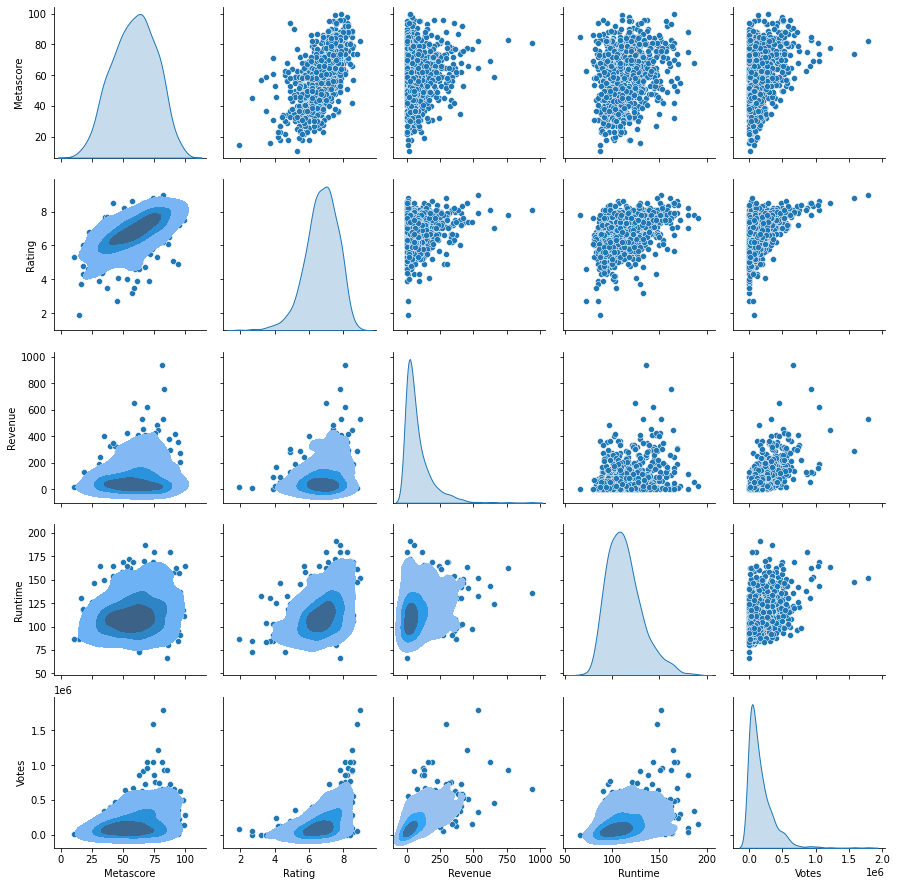

In [9]:
ax_pp = sns.pairplot(data=data.DF[data.DF.columns.difference(['Rank','Year'])], diag_kind="kde")
ax_pp.map_upper(sns.regplot, fit_reg=True, truncate=True)
ax_pp.map_lower(sns.kdeplot, shade=True, thresh=0.05, levels=4)
plt.show()

In [11]:
dfz = data.DF[[
    'Runtime',
    'Rating',
    'Votes',
    # 'Revenue',
    'Metascore',
]] \
# .apply(scipy.stats.zscore, nan_policy='omit')
# .apply(np.log)



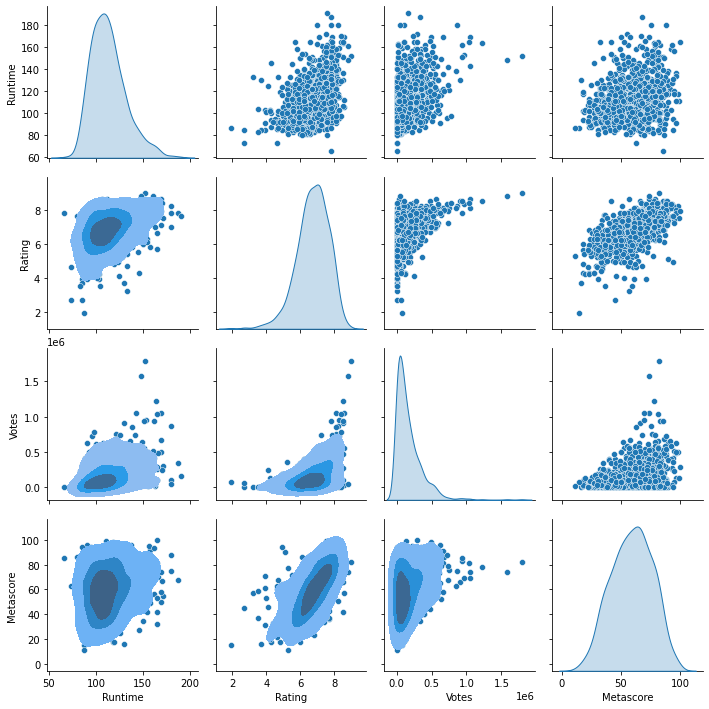

In [12]:
ax_pp = sns.pairplot(data=dfz, diag_kind="kde")
ax_pp.map_upper(sns.regplot, fit_reg=True, truncate=True)
ax_pp.map_lower(sns.kdeplot, shade=True, thresh=0.05, levels=4)
plt.show()

In [16]:
mod1 = smf.ols(formula='Revenue ~ Metascore + Rating + Votes', data=data.DF).fit()
(mod1.summary2())

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.421    
Dependent Variable: Revenue          AIC:                9716.7946
Date:               2020-11-04 23:56 BIC:                9735.7187
No. Observations:   838              Log-Likelihood:     -4854.4  
Df Model:           3                F-statistic:        203.7    
Df Residuals:       834              Prob (F-statistic): 4.10e-99 
R-squared:          0.423            Scale:              6327.0   
-------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept   136.7345   24.5042   5.5801  0.0000   88.6375  184.8316
Metascore     0.0834    0.2193   0.3802  0.7039   -0.3470    0.5137
Rating      -19.3831    4.6669  -4.1533  0.0000  -28.5434  -10.2228
Votes         0.0004    0.0000  23.3034  0.0000    0.0004    0.0004
------------------------------------------------------------------
Omnibus:              446.177      Durbin-Watson:         1.892   
Prob(Omnibus):        0.000        Jarque-Bera (JB):      5593.745
Skew:                 2.125        Prob(JB):              0.000   
Kurtosis:             14.922       Condition No.:         2472111 
==================================================================
* The condition number is large (2e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

In [17]:
mod2 = smf.ols(formula='Revenue ~ Metascore * Rating * Votes', data=data.DF).fit()
(mod2.summary2())

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                  OLS                Adj. R-squared:       0.471    
Dependent Variable:     Revenue            AIC:                  9644.5959
Date:                   2020-11-04 23:56   BIC:                  9682.4440
No. Observations:       838                Log-Likelihood:       -4814.3  
Df Model:               7                  F-statistic:          107.5    
Df Residuals:           830                Prob (F-statistic):   7.75e-112
R-squared:              0.476              Scale:                5777.3   
--------------------------------------------------------------------------
                         Coef.   Std.Err.    t    P>|t|    [0.025   0.975]
--------------------------------------------------------------------------
Intercept              -127.9933  87.5289 -1.4623 0.1440 -299.7973 43.8106
Metascore                 2.7516   1.4930  1.8430 0.0657   -0.1789  5.6822
Rating                   19.5748  13.6905  1.4298 0.1531   -7.2972 46.4469
Metascore:Rating         -0.4254   0.2207 -1.9277 0.0542   -0.8586  0.0078
Votes                     0.0017   0.0006  2.7953 0.0053    0.0005  0.0029
Metascore:Votes          -0.0000   0.0000 -0.1114 0.9113   -0.0000  0.0000
Rating:Votes             -0.0002   0.0001 -2.2812 0.0228   -0.0004 -0.0000
Metascore:Rating:Votes    0.0000   0.0000  0.3827 0.7020   -0.0000  0.0000
--------------------------------------------------------------------------
Omnibus:                503.030        Durbin-Watson:           1.855     
Prob(Omnibus):          0.000          Jarque-Bera (JB):        7538.061  
Skew:                   2.434          Prob(JB):                0.000     
Kurtosis:               16.864         Condition No.:           5239918714
==========================================================================
* The condition number is large (5e+09). This might indicate
strong multicollinearity or other numerical problems.
"""

In [18]:
def genre_network():
    df = data.df_genres
    didx = df.to_dict('index')  # {hash : {genre : 1|0}}
    
    connections = []
    for h,gd in didx.items():
        newgd = dict((k,v) for k,v in gd.items() if v==1)
        for genre in newgd.keys():
            other_genres = list(set(newgd.keys())-set([genre]))
            for og in other_genres:
                connec = {
                    'src_genre' : genre,
                    'tgt_genre' : og,
                    'hash'      : h,
                }
                connections.append(connec)
    df_connections = pd.DataFrame(connections)
    
    G = nx.from_pandas_edgelist(df_connections, source='src_genre',target='tgt_genre', edge_attr='hash')
    
    # genre_closeness = pd.DataFrame(dict((i, dict((j,nx.group_closeness_centrality(G, [i,j])) for j in data.df_genres.columns)) for i in data.df_genres.columns))
    
    return G
    
    

In [19]:
G_genre = genre_network()

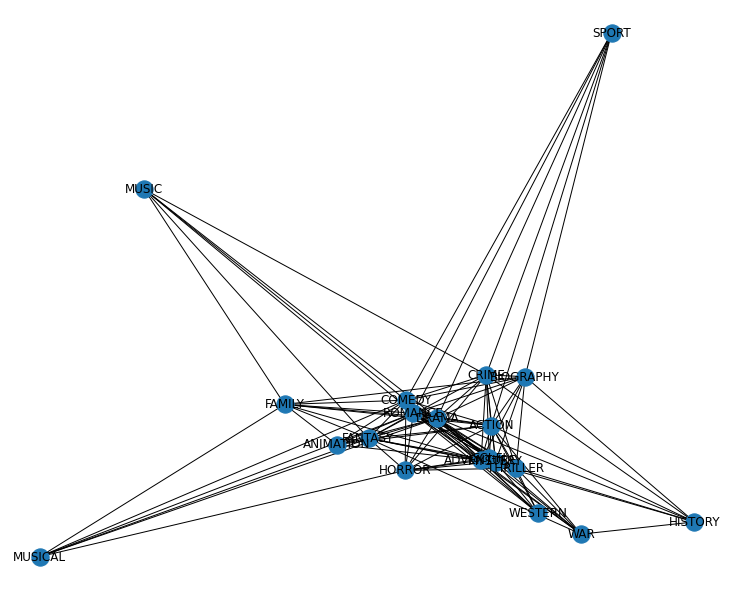

In [20]:
plt.figure(figsize=(10, 8))
nx.draw_spectral(G_genre, with_labels=True)

In [ ]:
list(nx.shortest_paths.all_shortest_paths(G_genre, source='MUSICAL',target='SPORT'))

In [21]:
dfsim = pd.DataFrame(nx.similarity.simrank_similarity(G_genre))
dfsim.loc[:,:] = np.where(dfsim.loc[:,:]>=1, np.nan, dfsim)
dfsim = dfsim.apply(scipy.stats.zscore, nan_policy='omit')
dfsim

,ACTION,ADVENTURE,SCI-FI,MYSTERY,HORROR,THRILLER,COMEDY,ANIMATION,FAMILY,FANTASY,DRAMA,MUSIC,BIOGRAPHY,ROMANCE,HISTORY,CRIME,WESTERN,WAR,MUSICAL,SPORT
ACTION,NaN,0.940670,-1.042809,-0.393379,-1.306797,0.037980,0.415658,-1.031133,-1.474461,-1.147389,1.247232,-0.377116,-0.535849,0.614928,-0.563632,-0.137561,-1.176800,-0.863636,-0.251752,-1.151364
ADVENTURE,1.523764,NaN,-0.847339,-0.000774,-1.071543,0.524383,-0.034197,-0.891853,-1.283620,-0.792330,1.044404,-0.234335,-0.732794,0.382986,-0.366466,-0.495786,-1.024474,-0.680435,-0.108734,-0.464960
SCI-FI,-0.122735,0.105174,NaN,0.933787,1.393461,0.868018,0.080221,0.259027,-0.407149,2.222361,-0.521571,0.177832,1.406149,-0.730246,1.193475,0.762057,1.873088,1.150301,0.280599,1.032284
MYSTERY,1.071927,1.197970,-0.071474,NaN,-0.086608,1.687033,0.225482,-0.350065,-0.395996,-0.861607,0.597095,-0.188083,-0.949467,0.497451,1.128031,0.138866,-0.410867,-0.494759,-0.072227,0.270402
HORROR,-0.855590,-0.664887,0.689357,0.336035,NaN,0.145024,1.021971,0.200676,0.490124,0.421395,0.029294,0.237122,0.309410,-0.051168,0.278229,0.357433,0.864324,0.901912,-0.237541,0.184156
THRILLER,1.259926,1.347489,-0.357500,0.992292,-0.463722,NaN,-0.877140,-0.553374,-0.770192,-1.400622,0.731483,-0.355877,-0.692596,-0.048635,0.129645,0.464256,-0.632184,-0.164839,-0.245392,-0.006380
COMEDY,0.039114,-0.708876,-1.060936,-1.017702,-0.820102,-1.414275,NaN,-1.030052,-0.240254,-0.364117,1.348974,-0.771581,-0.956792,1.332991,-0.571317,-0.106059,-1.175341,-0.884759,-0.662080,-1.176940
ANIMATION,-0.928152,-0.646881,0.524449,0.437957,1.049399,0.245750,-0.985011,NaN,2.347085,0.495075,-1.250929,1.888946,1.072831,-0.199787,-0.120947,-0.213808,1.362611,1.438958,2.102155,1.133922
FAMILY,-2.340353,-2.172969,-0.921005,-0.772657,-0.028310,-1.224930,1.459669,0.537560,NaN,0.420661,0.257564,-0.123442,-1.291773,1.110551,-0.253148,0.145689,-0.156570,-0.279550,0.012124,0.516062
FANTASY,-0.917915,-0.807671,0.105783,-1.227644,-0.442911,-1.727777,0.759284,-0.549145,0.044514,NaN,0.744311,-0.374773,-0.232991,0.743994,0.059230,-1.269965,-0.124621,-0.798306,-0.264203,-0.643414


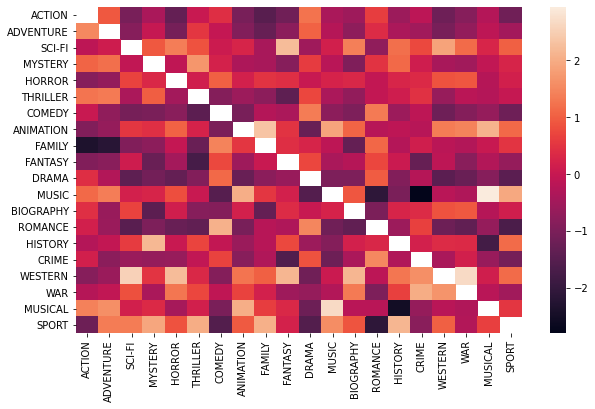

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(dfsim)
plt.show()